# wiki40b_jaコーパスをword2vecで学習する

In [11]:
# 必要なライブラリのインポート
from datasets import load_dataset
from gensim.models import Word2Vec
from sudachipy import tokenizer, dictionary
from tqdm import tqdm
import pickle
import os

In [12]:
# wiki40b_jaコーパスをロード
print("データセットをロード中...")
ds = load_dataset("fujiki/wiki40b_ja")
print(f"train: {len(ds['train'])}件")
print(f"validation: {len(ds['validation'])}件")
print(f"test: {len(ds['test'])}件")

データセットをロード中...
train: 745392件
validation: 41576件
test: 41268件


In [13]:
# SudachiPyの初期化（粒度C、full辞書）
tokenizer_obj = dictionary.Dictionary(dict="full").create()
mode = tokenizer.Tokenizer.SplitMode.C  # 粒度C（最も粗い分割）

def tokenize_text(text):
    """テキストをSudachiPyで分かち書きして単語リストに変換"""
    if not text or not isinstance(text, str):
        return []
    
    # SudachiPyの制限（49149バイト）を超える場合は分割処理
    max_bytes = 40000  # 安全マージンを持たせる
    
    all_words = []
    
    # テキストをバイト数で分割
    current_pos = 0
    while current_pos < len(text):
        # 次のチャンクを取得（文字数で概算）
        chunk_size = max_bytes // 3  # UTF-8で1文字最大3バイトと仮定
        chunk = text[current_pos:current_pos + chunk_size]
        
        # バイト数を確認
        while len(chunk.encode('utf-8')) > max_bytes and len(chunk) > 0:
            chunk = chunk[:-100]  # 少しずつ削る
        
        if not chunk:
            break
            
        try:
            # SudachiPyでトークナイズ
            tokens = tokenizer_obj.tokenize(chunk, mode)
            # 正規化形を取得
            words = [m.normalized_form() for m in tokens if len(m.normalized_form()) > 1]
            all_words.extend(words)
        except Exception as e:
            # エラーが出た場合はスキップ
            print(f"トークナイズエラー（スキップ）: {str(e)[:100]}")
        
        current_pos += len(chunk)
    
    return all_words

# テスト
sample_text = "これはテストです。日本語の形態素解析を行います。"
print("テスト:", tokenize_text(sample_text))

テスト: ['此れ', 'テスト', 'です', '日本語', '形態素解析', '行う', 'ます']


In [14]:
# コーパスをトークナイズ（文書ごとに単語リストに変換）
class TokenizedCorpus:
    """メモリ効率的にコーパスをトークナイズするイテレータ"""
    def __init__(self, dataset, max_docs=None):
        self.dataset = dataset
        self.max_docs = max_docs
        
    def __iter__(self):
        count = 0
        for item in self.dataset:
            if self.max_docs and count >= self.max_docs:
                break
            tokens = tokenize_text(item['text'])
            if tokens:  # 空でない場合のみ返す
                yield tokens
                count += 1

# 全データを使う場合（時間がかかる）
# tokenized_corpus = TokenizedCorpus(ds['train'])

# まずは一部でテスト（10万件）
tokenized_corpus = TokenizedCorpus(ds['train'], max_docs=100000)

print("トークナイズ済みコーパスを準備しました")

トークナイズ済みコーパスを準備しました


In [15]:
# Word2Vecモデルの学習
import logging

# ログ設定（学習状況を表示）
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

print("Word2Vecモデルを学習中...")

model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=300,        # ベクトルの次元数（100-300が一般的）
    window=5,               # 文脈ウィンドウサイズ
    min_count=5,            # 最低出現回数（5回未満の単語は無視）
    workers=4,              # 並列処理のワーカー数
    sg=0,                   # 0=CBOW, 1=Skip-gram（CBOWの方が高速）
    epochs=5,               # エポック数
    seed=42,                # 再現性のためのシード
    compute_loss=True       # 損失を計算して表示
)

print("\n学習完了!")
print(f"語彙数: {len(model.wv):,}語")
print(f"学習損失: {model.get_latest_training_loss():,.2f}")

2025-11-13 02:14:47,882 : INFO : collecting all words and their counts
2025-11-13 02:14:47,891 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Word2Vecモデルを学習中...


2025-11-13 02:14:53,396 : INFO : PROGRESS: at sentence #10000, processed 2418682 words, keeping 176535 word types
2025-11-13 02:14:58,809 : INFO : PROGRESS: at sentence #20000, processed 4805583 words, keeping 264426 word types
2025-11-13 02:15:04,473 : INFO : PROGRESS: at sentence #30000, processed 7255236 words, keeping 334098 word types
2025-11-13 02:15:10,056 : INFO : PROGRESS: at sentence #40000, processed 9664607 words, keeping 395249 word types
2025-11-13 02:15:15,725 : INFO : PROGRESS: at sentence #50000, processed 12081297 words, keeping 448430 word types
2025-11-13 02:15:21,492 : INFO : PROGRESS: at sentence #60000, processed 14598879 words, keeping 498551 word types
2025-11-13 02:15:27,235 : INFO : PROGRESS: at sentence #70000, processed 17077922 words, keeping 542880 word types
2025-11-13 02:15:33,399 : INFO : PROGRESS: at sentence #80000, processed 19625744 words, keeping 585659 word types
2025-11-13 02:15:39,369 : INFO : PROGRESS: at sentence #90000, processed 22077887 wo


学習完了!
語彙数: 189,480語
学習損失: 68,201,216.00


In [16]:
# モデルの保存
model_path = "../models/word2vec_wiki40b.model"
os.makedirs("../models", exist_ok=True)
model.save(model_path)
print(f"モデルを保存しました: {model_path}")

# 単語ベクトルのみを保存（軽量版）
wv_path = "../models/word2vec_wiki40b.wordvectors"
model.wv.save(wv_path)
print(f"単語ベクトルを保存しました: {wv_path}")

2025-11-13 02:20:57,104 : INFO : Word2Vec lifecycle event {'fname_or_handle': '../models/word2vec_wiki40b.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-11-13T02:20:57.104429', 'gensim': '4.4.0', 'python': '3.13.9 (main, Oct 28 2025, 12:02:14) [Clang 20.1.4 ]', 'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O', 'event': 'saving'}
2025-11-13 02:20:57,106 : INFO : storing np array 'vectors' to ../models/word2vec_wiki40b.model.wv.vectors.npy
2025-11-13 02:20:57,153 : INFO : storing np array 'syn1neg' to ../models/word2vec_wiki40b.model.syn1neg.npy
2025-11-13 02:20:57,195 : INFO : not storing attribute cum_table
2025-11-13 02:20:57,252 : INFO : saved ../models/word2vec_wiki40b.model
2025-11-13 02:20:57,253 : INFO : KeyedVectors lifecycle event {'fname_or_handle': '../models/word2vec_wiki40b.wordvectors', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-11-13T02:20:57.253403', 'gensim': '4.4.0', 'python': '3.1

モデルを保存しました: ../models/word2vec_wiki40b.model


2025-11-13 02:20:57,319 : INFO : saved ../models/word2vec_wiki40b.wordvectors


単語ベクトルを保存しました: ../models/word2vec_wiki40b.wordvectors


## モデルの評価とテスト

In [17]:
# 類似単語の検索テスト
test_words = ["日本", "東京", "コンピュータ", "野球", "音楽", "経済"]

for word in test_words:
    if word in model.wv:
        print(f"\n【{word}】に類似する単語:")
        similar_words = model.wv.most_similar(word, topn=10)
        for similar_word, score in similar_words:
            print(f"  {similar_word}: {score:.4f}")
    else:
        print(f"\n【{word}】は語彙に含まれていません")


【日本】に類似する単語:
  韓国: 0.6393
  日本国内: 0.5669
  日本人: 0.5481
  台湾: 0.5209
  アメリカ: 0.5166
  朝鮮: 0.4950
  海外: 0.4824
  欧米: 0.4795
  中国: 0.4786
  外国: 0.4699

【東京】に類似する単語:
  大阪: 0.8376
  名古屋: 0.6979
  京都: 0.6748
  神戸: 0.6356
  札幌: 0.6010
  横浜: 0.5957
  関西: 0.5852
  福岡: 0.5463
  新宿: 0.5340
  函館: 0.5311

【コンピュータ】は語彙に含まれていません

【野球】に類似する単語:
  サッカー: 0.7134
  社会人: 0.7027
  バスケットボール: 0.6946
  プロ野球: 0.6826
  野球部: 0.6800
  ソフトボール: 0.6725
  アメリカン・フットボール: 0.6668
  バレーボール: 0.6634
  高校野球: 0.6616
  少年野球: 0.6573

【音楽】に類似する単語:
  クラシック音楽: 0.7354
  ジャズ: 0.6625
  電子音楽: 0.6349
  ポピュラー音楽: 0.6335
  演奏: 0.6331
  楽器: 0.6287
  伴奏: 0.6277
  洋楽: 0.6267
  音楽的: 0.6263
  宗教音楽: 0.6254

【経済】に類似する単語:
  金融: 0.7583
  経済成長: 0.7176
  産業: 0.6894
  社会資本: 0.6791
  経済政策: 0.6775
  経済状況: 0.6625
  不況: 0.6523
  経済発展: 0.6506
  経済開発: 0.6482
  工業化: 0.6470


In [18]:
# 単語の類推テスト（王様 - 男性 + 女性 = 女王）
print("=" * 80)
print("単語の類推テスト")
print("=" * 80)

analogy_tests = [
    ("東京", "日本", "パリ"),  # 東京:日本 = パリ:?
    ("男性", "王", "女性"),     # 男性:王 = 女性:?
    ("大きい", "大", "小さい"), # 大きい:大 = 小さい:?
]

for positive1, positive2, negative in analogy_tests:
    try:
        # positive1 - positive2 + negative に近い単語
        result = model.wv.most_similar(
            positive=[negative, positive2], 
            negative=[positive1], 
            topn=5
        )
        print(f"\n{positive1} - {positive2} + {negative} =")
        for word, score in result:
            print(f"  {word}: {score:.4f}")
    except KeyError as e:
        print(f"\n{positive1} - {positive2} + {negative} = エラー: {e}")

単語の類推テスト

東京 - 日本 + パリ =
  フランス: 0.7047
  イギリス: 0.6013
  スペイン: 0.5994
  ヨーロッパ: 0.5824
  オランダ: 0.5808

男性 - 王 + 女性 = エラー: "Key '王' not present in vocabulary"

大きい - 大 + 小さい = エラー: "Key '大' not present in vocabulary"


t-SNEで次元削減中...


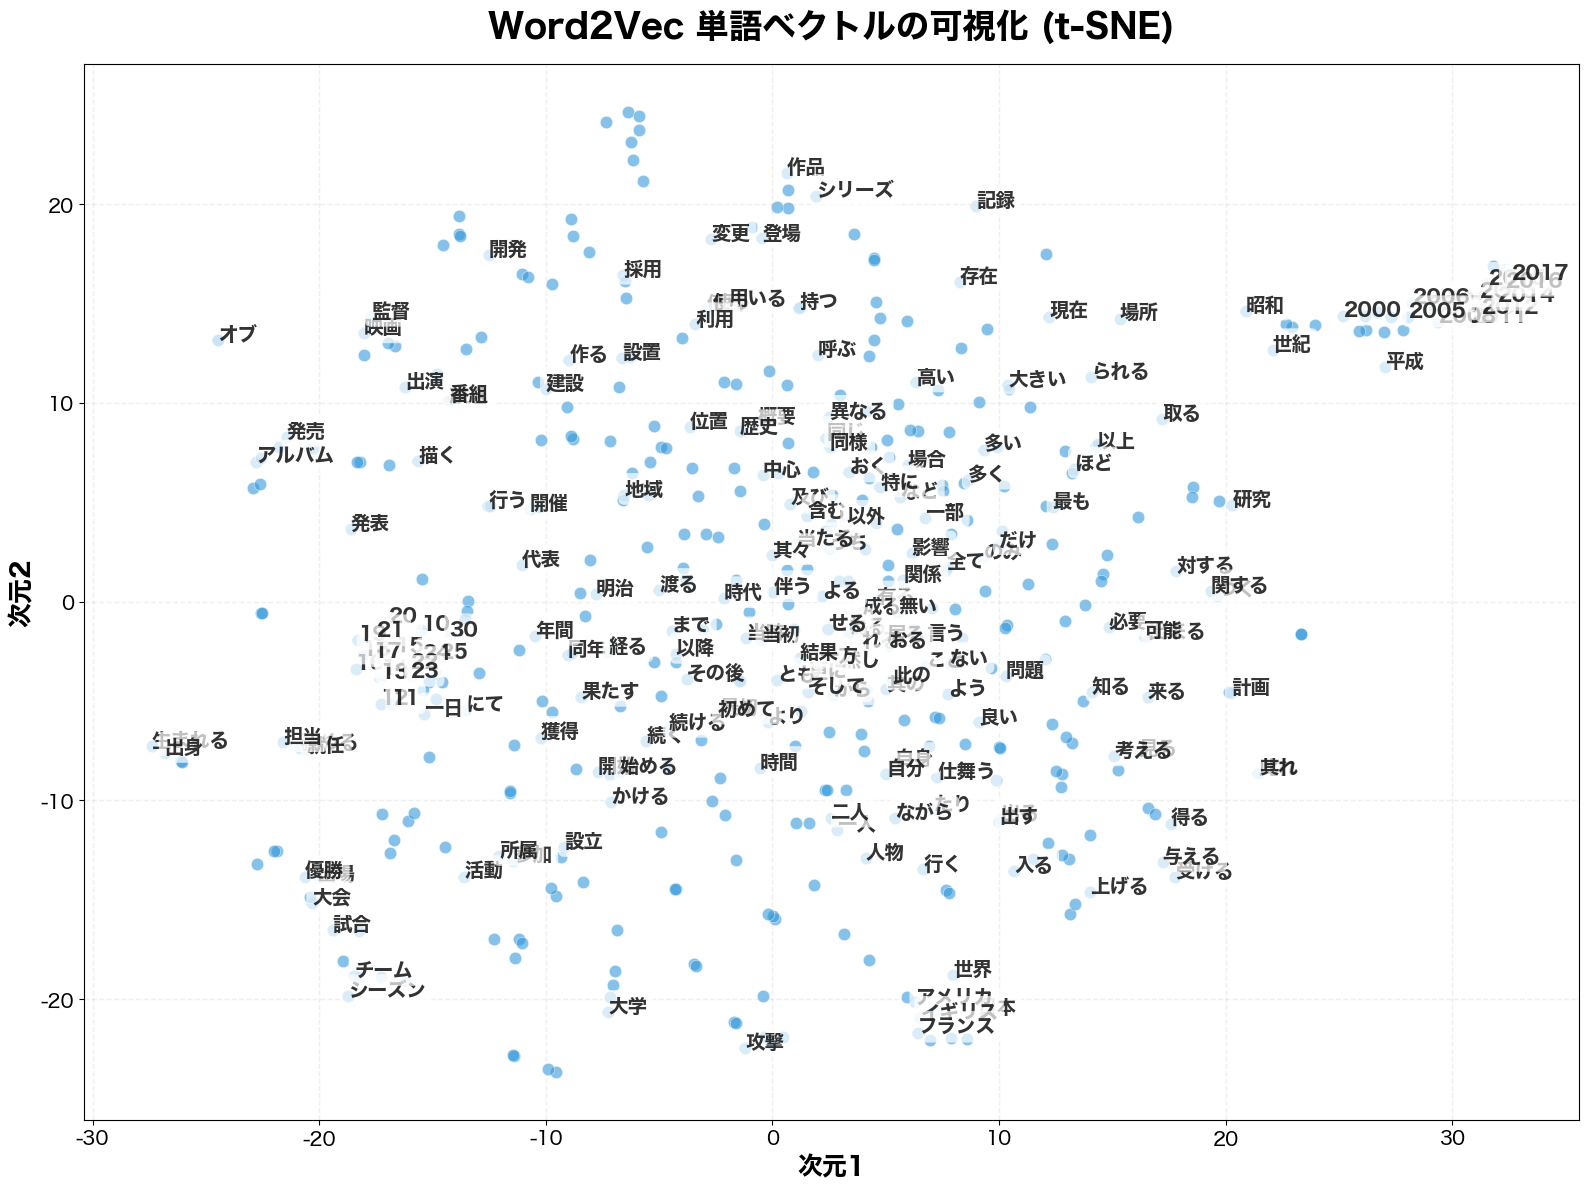

500語を可視化しました


In [22]:
# 単語ベクトルの可視化（t-SNE）
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 頻出上位500語を可視化
vocab_size = min(500, len(model.wv))
words = list(model.wv.index_to_key[:vocab_size])
word_vectors = np.array([model.wv[word] for word in words])

# t-SNEで2次元に圧縮
print("t-SNEで次元削減中...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_2d = tsne.fit_transform(word_vectors)

# プロット（スライド用に調整）
plt.figure(figsize=(16, 12), dpi=100)
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], 
           alpha=0.6, s=80, c='#3498db', edgecolors='white', linewidth=0.5)

# 一部の単語をラベル表示
for i in range(0, min(200, vocab_size), 1):
    plt.annotate(words[i], 
                xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                fontsize=14,
                fontweight='bold',
                alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7))

plt.title('Word2Vec 単語ベクトルの可視化 (t-SNE)', fontsize=24, fontweight='bold', pad=20)
plt.xlabel('次元1', fontsize=18, fontweight='bold')
plt.ylabel('次元2', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.2, linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print(f"{vocab_size}語を可視化しました")

In [20]:
# モデルの統計情報
print("=" * 80)
print("モデルの統計情報")
print("=" * 80)
print(f"語彙数: {len(model.wv):,}語")
print(f"ベクトル次元数: {model.wv.vector_size}")
print(f"ウィンドウサイズ: {model.window}")
print(f"最小出現回数: {model.min_count}")
print(f"学習アルゴリズム: {'Skip-gram' if model.sg else 'CBOW'}")
print(f"エポック数: {model.epochs}")

# 頻出単語トップ20
print("\n頻出単語トップ20:")
for i, word in enumerate(model.wv.index_to_key[:20], 1):
    print(f"{i:2d}. {word}")

モデルの統計情報
語彙数: 189,480語
ベクトル次元数: 300
ウィンドウサイズ: 5
最小出現回数: 5
学習アルゴリズム: CBOW
エポック数: 5

頻出単語トップ20:
 1. 為る
 2. れる
 3. 居る
 4. 有る
 5. から
 6. 成る
 7. こと
 8. よる
 9. 言う
10. など
11. 其の
12. 此の
13. ない
14. られる
15. 無い
16. よう
17. 行う
18. まで
19. 此れ
20. 日本


## 全データで学習する場合（オプション）

以下のセルを実行すると、全74万件のデータで学習します（数時間かかる可能性があります）

In [23]:
# 全データで学習（コメントアウトを解除して実行）

print("全データでWord2Vecモデルを学習中...")

# 全データを使用
full_corpus = TokenizedCorpus(ds['train'], max_docs=None)

# より大規模なモデル
full_model = Word2Vec(
    sentences=full_corpus,
    vector_size=300,
    window=5,
    min_count=10,           # 出現回数の閾値を上げる
    workers=8,              # ワーカー数を増やす
    sg=1,                   # Skip-gramを使用（精度重視）
    epochs=5,
    seed=42
)

# 保存
full_model.save("../results/models/word2vec_wiki40b_full.model")
full_model.wv.save("../results/models/word2vec_wiki40b_full.wordvectors")

print(f"学習完了! 語彙数: {len(full_model.wv):,}語")


2025-11-13 02:28:59,684 : INFO : collecting all words and their counts
2025-11-13 02:28:59,705 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


全データでWord2Vecモデルを学習中...


2025-11-13 02:29:05,351 : INFO : PROGRESS: at sentence #10000, processed 2418682 words, keeping 176535 word types
2025-11-13 02:29:10,981 : INFO : PROGRESS: at sentence #20000, processed 4805583 words, keeping 264426 word types
2025-11-13 02:29:16,681 : INFO : PROGRESS: at sentence #30000, processed 7255236 words, keeping 334098 word types
2025-11-13 02:29:22,543 : INFO : PROGRESS: at sentence #40000, processed 9664607 words, keeping 395249 word types
2025-11-13 02:29:28,061 : INFO : PROGRESS: at sentence #50000, processed 12081297 words, keeping 448430 word types
2025-11-13 02:29:33,797 : INFO : PROGRESS: at sentence #60000, processed 14598879 words, keeping 498551 word types
2025-11-13 02:29:39,859 : INFO : PROGRESS: at sentence #70000, processed 17077922 words, keeping 542880 word types
2025-11-13 02:29:45,912 : INFO : PROGRESS: at sentence #80000, processed 19625744 words, keeping 585659 word types
2025-11-13 02:29:51,932 : INFO : PROGRESS: at sentence #90000, processed 22077887 wo

学習完了! 語彙数: 393,381語


## Fullモデルの読み込みと評価

In [25]:
# Fullモデルの読み込み
from gensim.models import Word2Vec, KeyedVectors
import os

# モデルパスの確認
full_model_path = "../results/models/word2vec_wiki40b_full.model"
full_wv_path = "../results/models/word2vec_wiki40b_full.wordvectors"

if os.path.exists(full_model_path):
    print("Fullモデルを読み込み中...")
    full_model = Word2Vec.load(full_model_path)
    print(f"✓ モデル読み込み完了")
    print(f"  語彙数: {len(full_model.wv):,}語")
    print(f"  ベクトル次元: {full_model.wv.vector_size}")
elif os.path.exists(full_wv_path):
    print("単語ベクトルのみ読み込み中...")
    full_model_wv = KeyedVectors.load(full_wv_path)
    print(f"✓ 単語ベクトル読み込み完了")
    print(f"  語彙数: {len(full_model_wv):,}語")
    print(f"  ベクトル次元: {full_model_wv.vector_size}")
    # 以降の評価用に変数を統一
    full_model = type('obj', (object,), {'wv': full_model_wv})()
else:
    print("⚠ Fullモデルが見つかりません")
    print(f"  期待パス: {full_model_path}")
    print("  先に全データで学習を実行してください")

2025-11-13 13:19:21,218 : INFO : loading Word2Vec object from ../results/models/word2vec_wiki40b_full.model
2025-11-13 13:19:21,287 : INFO : loading wv recursively from ../results/models/word2vec_wiki40b_full.model.wv.* with mmap=None
2025-11-13 13:19:21,287 : INFO : loading vectors from ../results/models/word2vec_wiki40b_full.model.wv.vectors.npy with mmap=None


Fullモデルを読み込み中...


2025-11-13 13:19:21,430 : INFO : loading syn1neg from ../results/models/word2vec_wiki40b_full.model.syn1neg.npy with mmap=None
2025-11-13 13:19:21,550 : INFO : setting ignored attribute cum_table to None
2025-11-13 13:19:22,193 : INFO : Word2Vec lifecycle event {'fname': '../results/models/word2vec_wiki40b_full.model', 'datetime': '2025-11-13T13:19:22.193434', 'gensim': '4.4.0', 'python': '3.13.9 (main, Oct 28 2025, 12:02:14) [Clang 20.1.4 ]', 'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O', 'event': 'loaded'}


✓ モデル読み込み完了
  語彙数: 393,381語
  ベクトル次元: 300


In [26]:
# 基本的な類似語検索テスト
print("=" * 80)
print("類似語検索テスト（Fullモデル）")
print("=" * 80)

test_words = [
    "日本", "東京", "大阪", "京都",
    "コンピュータ", "プログラミング", "人工知能",
    "野球", "サッカー", "テニス",
    "音楽", "映画", "小説",
    "経済", "政治", "科学",
    "大学", "研究", "教育"
]

for word in test_words:
    if word in full_model.wv:
        print(f"\n【{word}】に類似する単語 (Top 5):")
        similar_words = full_model.wv.most_similar(word, topn=5)
        for i, (similar_word, score) in enumerate(similar_words, 1):
            print(f"  {i}. {similar_word:15s} (類似度: {score:.4f})")
    else:
        print(f"\n【{word}】は語彙に含まれていません")

類似語検索テスト（Fullモデル）

【日本】に類似する単語 (Top 5):
  1. 日本国内            (類似度: 0.6433)
  2. 青年海外協力協会        (類似度: 0.4994)
  3. 韓国              (類似度: 0.4994)
  4. 作詩家             (類似度: 0.4973)
  5. jbby            (類似度: 0.4912)

【東京】に類似する単語 (Top 5):
  1. 大阪              (類似度: 0.6780)
  2. 名古屋             (類似度: 0.6025)
  3. 千歳高等学校          (類似度: 0.6024)
  4. 都立              (類似度: 0.5992)
  5. 品川              (類似度: 0.5848)

【大阪】に類似する単語 (Top 5):
  1. 名古屋             (類似度: 0.7059)
  2. 東京              (類似度: 0.6780)
  3. 大阪市             (類似度: 0.6665)
  4. 心斎橋             (類似度: 0.6508)
  5. 神戸              (類似度: 0.6463)

【京都】に類似する単語 (Top 5):
  1. 奈良              (類似度: 0.6762)
  2. 京都市             (類似度: 0.6643)
  3. 嵯峨野             (類似度: 0.6378)
  4. 花灯路             (類似度: 0.6335)
  5. 洛北              (類似度: 0.6178)

【コンピュータ】は語彙に含まれていません

【プログラミング】に類似する単語 (Top 5):
  1. プログラミング言語       (類似度: 0.7367)
  2. コンピュータ言語        (類似度: 0.6851)
  3. 関数プログラミング       (類似度: 0.6810)
  4. プログラミングパラダイム    (類似度: 0.6798)
  5. 

In [27]:
# 単語類推テスト（アナロジー）
print("=" * 80)
print("単語類推テスト（Fullモデル）")
print("=" * 80)

analogy_tests = [
    # 地理的関係
    ("東京", "日本", "パリ", "東京:日本 = パリ:?"),
    ("大阪", "日本", "ニューヨーク", "大阪:日本 = ニューヨーク:?"),
    
    # 性別関係
    ("男性", "王", "女性", "男性:王 = 女性:?"),
    ("男", "俳優", "女", "男:俳優 = 女:?"),
    
    # サイズ関係
    ("大きい", "大", "小さい", "大きい:大 = 小さい:?"),
    ("高い", "高", "低い", "高い:高 = 低い:?"),
    
    # 時制関係
    ("現在", "今", "過去", "現在:今 = 過去:?"),
    
    # スポーツと選手
    ("野球", "選手", "サッカー", "野球:選手 = サッカー:?"),
    
    # 学問分野
    ("数学", "数", "物理", "数学:数 = 物理:?"),
]

for word1, word2, word3, description in analogy_tests:
    print(f"\n{description}")
    try:
        # word1 - word2 + word3 に近い単語
        result = full_model.wv.most_similar(
            positive=[word3, word2], 
            negative=[word1], 
            topn=5
        )
        print(f"  予測結果:")
        for i, (word, score) in enumerate(result, 1):
            print(f"    {i}. {word:15s} (スコア: {score:.4f})")
    except KeyError as e:
        print(f"  ⚠ エラー: 単語 {e} が語彙に含まれていません")

単語類推テスト（Fullモデル）

東京:日本 = パリ:?
  予測結果:
    1. フランス            (スコア: 0.6036)
    2. ヨーロッパ           (スコア: 0.4930)
    3. ベルギー            (スコア: 0.4927)
    4. リヨン             (スコア: 0.4682)
    5. アンリ             (スコア: 0.4670)

大阪:日本 = ニューヨーク:?
  予測結果:
    1. アメリカ            (スコア: 0.5229)
    2. アメリカ合衆国         (スコア: 0.4932)
    3. 米国              (スコア: 0.4870)
    4. ボストン            (スコア: 0.4746)
    5. ニューヨーク市         (スコア: 0.4675)

男性:王 = 女性:?
  ⚠ エラー: 単語 "Key '王' not present in vocabulary" が語彙に含まれていません

男:俳優 = 女:?
  ⚠ エラー: 単語 "Key '女' not present in vocabulary" が語彙に含まれていません

大きい:大 = 小さい:?
  ⚠ エラー: 単語 "Key '大' not present in vocabulary" が語彙に含まれていません

高い:高 = 低い:?
  ⚠ エラー: 単語 "Key '高' not present in vocabulary" が語彙に含まれていません

現在:今 = 過去:?
  ⚠ エラー: 単語 "Key '今' not present in vocabulary" が語彙に含まれていません

野球:選手 = サッカー:?
  予測結果:
    1. 代表選手            (スコア: 0.5797)
    2. 若手選手            (スコア: 0.5751)
    3. サッカー選手          (スコア: 0.5719)
    4. レフトバック          (スコア: 0.5677)
    5. ゴールキーパー        

In [30]:
# 単語間の類似度計算
print("=" * 80)
print("単語間の類似度計算（Fullモデル）")
print("=" * 80)

similarity_pairs = [
    # 同義語・類義語
    ("コンピュータ", "パソコン"),
    ("自動車", "車"),
    ("映画", "ムービー"),
    
    # 関連語
    ("東京", "日本"),
    ("野球", "スポーツ"),
    ("大学", "教育"),
    ("医者", "病院"),
    
    # 対義語
    ("大きい", "小さい"),
    ("高い", "低い"),
    ("良い", "悪い"),
    
    # 無関係な単語
    ("コンピュータ", "野球"),
    ("音楽", "経済"),
    ("映画", "数学"),
]

print("\n単語ペアの類似度:")
for word1, word2 in similarity_pairs:
    try:
        similarity = full_model.wv.similarity(word1, word2)
        print(f"  {word1:12s} ⟷ {word2:12s} : {similarity:.4f}")
    except KeyError as e:
        print(f"  {word1:12s} ⟷ {word2:12s} : エラー（単語 {e} が未登録）")

単語間の類似度計算（Fullモデル）

単語ペアの類似度:
  コンピュータ       ⟷ パソコン         : エラー（単語 "Key 'コンピュータ' not present" が未登録）
  自動車          ⟷ 車            : エラー（単語 "Key '車' not present" が未登録）
  映画           ⟷ ムービー         : 0.5482
  東京           ⟷ 日本           : 0.3298
  野球           ⟷ スポーツ         : 0.4874
  大学           ⟷ 教育           : 0.3757
  医者           ⟷ 病院           : 0.4211
  大きい          ⟷ 小さい          : 0.6900
  高い           ⟷ 低い           : 0.8752
  良い           ⟷ 悪い           : 0.7657
  コンピュータ       ⟷ 野球           : エラー（単語 "Key 'コンピュータ' not present" が未登録）
  音楽           ⟷ 経済           : 0.2544
  映画           ⟷ 数学           : 0.1636


In [31]:
# 仲間外れ検出テスト
print("=" * 80)
print("仲間外れ検出テスト（Fullモデル）")
print("=" * 80)

outlier_tests = [
    ["朝", "昼", "夜", "リンゴ"],
    ["東京", "大阪", "京都", "アメリカ"],
    ["野球", "サッカー", "テニス", "音楽"],
    ["犬", "猫", "鳥", "自動車"],
    ["赤", "青", "緑", "大きい"],
    ["春", "夏", "秋", "月曜日"],
]

print("\n仲間外れを検出:")
for words in outlier_tests:
    try:
        # 語彙に含まれる単語のみでフィルタ
        valid_words = [w for w in words if w in full_model.wv]
        if len(valid_words) < 2:
            print(f"  {words} : スキップ（語彙不足）")
            continue
            
        outlier = full_model.wv.doesnt_match(valid_words)
        print(f"  {words}")
        print(f"    → 仲間外れ: 【{outlier}】")
    except Exception as e:
        print(f"  {words} : エラー - {str(e)[:50]}")

仲間外れ検出テスト（Fullモデル）

仲間外れを検出:
  ['朝', '昼', '夜', 'リンゴ'] : スキップ（語彙不足）
  ['東京', '大阪', '京都', 'アメリカ']
    → 仲間外れ: 【アメリカ】
  ['野球', 'サッカー', 'テニス', '音楽']
    → 仲間外れ: 【音楽】
  ['犬', '猫', '鳥', '自動車'] : スキップ（語彙不足）
  ['赤', '青', '緑', '大きい'] : スキップ（語彙不足）
  ['春', '夏', '秋', '月曜日'] : スキップ（語彙不足）


In [32]:
# 語彙統計情報
print("=" * 80)
print("Fullモデルの語彙統計")
print("=" * 80)

print(f"\n基本情報:")
print(f"  総語彙数: {len(full_model.wv):,}語")
print(f"  ベクトル次元: {full_model.wv.vector_size}")

print(f"\n頻出単語 Top 30:")
for i, word in enumerate(full_model.wv.index_to_key[:30], 1):
    print(f"  {i:2d}. {word}")

print(f"\n低頻度単語（末尾10語）:")
for i, word in enumerate(full_model.wv.index_to_key[-10:], 1):
    print(f"  {i:2d}. {word}")

Fullモデルの語彙統計

基本情報:
  総語彙数: 393,381語
  ベクトル次元: 300

頻出単語 Top 30:
   1. 為る
   2. れる
   3. 居る
   4. 有る
   5. から
   6. 成る
   7. こと
   8. よる
   9. 言う
  10. など
  11. 其の
  12. 此の
  13. ない
  14. られる
  15. 無い
  16. 行う
  17. よう
  18. まで
  19. 此れ
  20. 日本
  21. 出来る
  22. 10
  23. おく
  24. おる
  25. より
  26. せる
  27. 12
  28. 其れ
  29. 11
  30. 現在

低頻度単語（末尾10語）:
   1. エスカレラ
   2. 高野由美
   3. 広島新庄高等学校
   4. 199000
   5. 新山志保
   6. ジャン・ギャロン
   7. penpoint
   8. ジャーディ
   9. 国家の品格
  10. 渡辺勝彦


In [ ]:
# 単語ベクトルの可視化(t-SNE)

特定ドメインの単語クラスタリング

23語をt-SNEで可視化中...


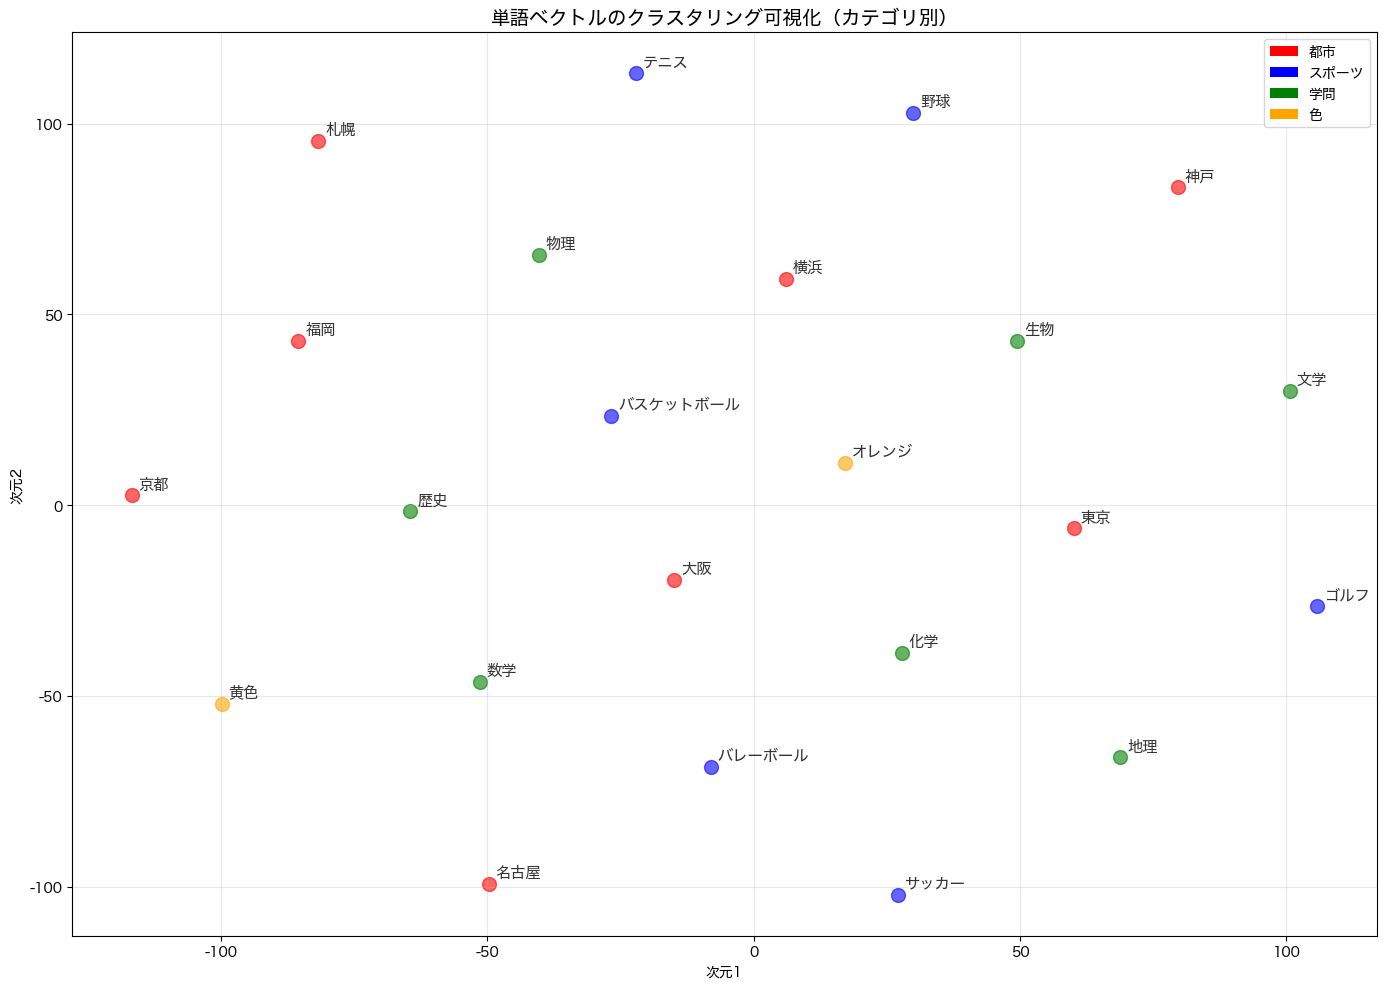

✓ 可視化完了


In [33]:
# 特定ドメインの単語クラスタリング分析
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("=" * 80)
print("特定ドメインの単語クラスタリング")
print("=" * 80)

# 分析対象の単語群
domain_words = {
    "都市": ["東京", "大阪", "京都", "名古屋", "福岡", "札幌", "横浜", "神戸"],
    "スポーツ": ["野球", "サッカー", "テニス", "バスケットボール", "バレーボール", "ゴルフ"],
    "学問": ["数学", "物理", "化学", "生物", "歴史", "地理", "文学"],
    "色": ["赤", "青", "緑", "黄色", "黒", "白", "紫", "オレンジ"],
}

# 語彙に存在する単語のみ抽出
all_words = []
word_labels = []
for category, words in domain_words.items():
    for word in words:
        if word in full_model.wv:
            all_words.append(word)
            word_labels.append(category)

if len(all_words) > 0:
    # 単語ベクトルを取得
    word_vectors = np.array([full_model.wv[word] for word in all_words])
    
    # t-SNEで2次元に圧縮
    print(f"\n{len(all_words)}語をt-SNEで可視化中...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_words)-1))
    word_vectors_2d = tsne.fit_transform(word_vectors)
    
    # カテゴリごとに色分けしてプロット
    plt.figure(figsize=(14, 10))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    category_colors = {cat: colors[i % len(colors)] for i, cat in enumerate(domain_words.keys())}
    
    for i, (word, category) in enumerate(zip(all_words, word_labels)):
        x, y = word_vectors_2d[i]
        plt.scatter(x, y, c=category_colors[category], s=100, alpha=0.6)
        plt.annotate(word, xy=(x, y), xytext=(5, 5), 
                    textcoords='offset points', fontsize=11, alpha=0.8)
    
    # 凡例
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=category_colors[cat], label=cat) 
                      for cat in domain_words.keys()]
    plt.legend(handles=legend_elements, loc='best', fontsize=10)
    
    plt.title('単語ベクトルのクラスタリング可視化（カテゴリ別）', fontsize=14)
    plt.xlabel('次元1')
    plt.ylabel('次元2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ 可視化完了")
else:
    print("⚠ 語彙に含まれる単語が見つかりませんでした")

In [34]:
# カスタム単語検索（インタラクティブ）
print("=" * 80)
print("カスタム単語検索")
print("=" * 80)

def search_similar_words(word, topn=10):
    """指定した単語の類似語を検索"""
    if word not in full_model.wv:
        print(f"⚠ 単語「{word}」は語彙に含まれていません")
        
        # 部分一致で候補を提案
        candidates = [w for w in full_model.wv.index_to_key[:10000] if word in w]
        if candidates:
            print(f"\n類似の単語候補（部分一致）:")
            for i, candidate in enumerate(candidates[:10], 1):
                print(f"  {i}. {candidate}")
        return
    
    print(f"\n【{word}】に類似する単語 (Top {topn}):")
    similar_words = full_model.wv.most_similar(word, topn=topn)
    for i, (similar_word, score) in enumerate(similar_words, 1):
        print(f"  {i:2d}. {similar_word:20s} (類似度: {score:.4f})")

# テスト検索
test_queries = ["人工知能", "機械学習", "プログラミング"]
for query in test_queries:
    search_similar_words(query, topn=10)
    print()

カスタム単語検索

【人工知能】に類似する単語 (Top 10):
   1. ロボット工学               (類似度: 0.6671)
   2. AI                   (類似度: 0.6656)
   3. ディープラーニング            (類似度: 0.6583)
   4. 機械学習                 (類似度: 0.6576)
   5. ロドニー・ブルックス           (類似度: 0.6542)
   6. 人工意識                 (類似度: 0.6473)
   7. マービン・ミンスキー           (類似度: 0.6468)
   8. アーティフィシャルインテリジェンス    (類似度: 0.6464)
   9. クレバーボット              (類似度: 0.6409)
  10. 自然言語処理               (類似度: 0.6401)


【機械学習】に類似する単語 (Top 10):
   1. 深層学習                 (類似度: 0.7887)
   2. Neural Network       (類似度: 0.7827)
   3. データマイニング             (類似度: 0.7708)
   4. データ駆動                (類似度: 0.7569)
   5. 抽象解釈                 (類似度: 0.7567)
   6. ファジィ制御               (類似度: 0.7541)
   7. モデルベーステスト            (類似度: 0.7489)
   8. 線形計画法                (類似度: 0.7471)
   9. 言語モデル                (類似度: 0.7466)
  10. 数理モデル                (類似度: 0.7461)


【プログラミング】に類似する単語 (Top 10):
   1. プログラミング言語            (類似度: 0.7367)
   2. コンピュータ言語             (類似度: 0.6851)
   3. 関数プ

In [35]:
# ベクトル演算テスト（複雑な類推）
print("=" * 80)
print("ベクトル演算テスト（複雑な類推）")
print("=" * 80)

def vector_analogy(positive_words, negative_words, topn=5):
    """
    ベクトル演算による類推
    positive_words: 足す単語のリスト
    negative_words: 引く単語のリスト
    """
    try:
        result = full_model.wv.most_similar(
            positive=positive_words,
            negative=negative_words,
            topn=topn
        )
        
        pos_str = " + ".join(positive_words)
        neg_str = " - ".join(negative_words)
        print(f"\n{pos_str} - {neg_str} =")
        
        for i, (word, score) in enumerate(result, 1):
            print(f"  {i}. {word:20s} (スコア: {score:.4f})")
            
    except KeyError as e:
        print(f"\n⚠ エラー: 単語 {e} が語彙に含まれていません")

# 複雑な類推テスト
print("\n【地理的関係】")
vector_analogy(["パリ", "日本"], ["フランス"])

print("\n【職業と性別】")
vector_analogy(["女性", "医者"], ["男性"])

print("\n【時間的関係】")
vector_analogy(["未来", "過去"], ["現在"])

print("\n【学問分野】")
vector_analogy(["物理学", "数"], ["数学"])

print("\n【スポーツと道具】")
vector_analogy(["サッカー", "野球"], ["ボール"])

ベクトル演算テスト（複雑な類推）

【地理的関係】

パリ + 日本 - フランス =
  1. 日本国内                 (スコア: 0.4980)
  2. 東京                   (スコア: 0.4685)
  3. 国際浮世絵学会              (スコア: 0.4496)
  4. 太平洋美術会               (スコア: 0.4495)
  5. 日本南画院                (スコア: 0.4482)

【職業と性別】

女性 + 医者 - 男性 =
  1. 医師                   (スコア: 0.6236)
  2. 名医                   (スコア: 0.5409)
  3. 藪医者                  (スコア: 0.5174)
  4. 眼科医                  (スコア: 0.5024)
  5. 往診                   (スコア: 0.5010)

【時間的関係】

未来 + 過去 - 現在 =
  1. 時間跳躍                 (スコア: 0.4593)
  2. 野上良太郎                (スコア: 0.4525)
  3. 地球の危機                (スコア: 0.4486)
  4. 時間軸                  (スコア: 0.4399)
  5. 衛宮士郎                 (スコア: 0.4326)

【学問分野】

⚠ エラー: 単語 "Key '数' not present in vocabulary" が語彙に含まれていません

【スポーツと道具】

サッカー + 野球 - ボール =
  1. バレーボール               (スコア: 0.6367)
  2. バスケットボール             (スコア: 0.6149)
  3. ラグビー                 (スコア: 0.5840)
  4. クラブチーム               (スコア: 0.5779)
  5. 陸上競技                 (スコア: 0.5763)


In [36]:
# モデル性能の定量評価
print("=" * 80)
print("モデル性能の定量評価")
print("=" * 80)

# 類似度相関テスト用のデータ
similarity_test_data = [
    # (単語1, 単語2, 期待される類似度レベル: high/medium/low)
    ("コンピュータ", "パソコン", "high"),
    ("自動車", "車", "high"),
    ("東京", "日本", "high"),
    ("野球", "スポーツ", "medium"),
    ("医者", "病院", "medium"),
    ("音楽", "映画", "medium"),
    ("コンピュータ", "野球", "low"),
    ("音楽", "数学", "low"),
]

print("\n類似度スコア分布:")
high_scores = []
medium_scores = []
low_scores = []

for word1, word2, level in similarity_test_data:
    try:
        score = full_model.wv.similarity(word1, word2)
        print(f"  {word1:15s} ⟷ {word2:15s} : {score:.4f} ({level})")
        
        if level == "high":
            high_scores.append(score)
        elif level == "medium":
            medium_scores.append(score)
        else:
            low_scores.append(score)
    except KeyError:
        print(f"  {word1:15s} ⟷ {word2:15s} : スキップ（語彙なし）")

# 統計サマリ
if high_scores:
    print(f"\n高関連語ペアの平均類似度: {np.mean(high_scores):.4f} (±{np.std(high_scores):.4f})")
if medium_scores:
    print(f"中関連語ペアの平均類似度: {np.mean(medium_scores):.4f} (±{np.std(medium_scores):.4f})")
if low_scores:
    print(f"低関連語ペアの平均類似度: {np.mean(low_scores):.4f} (±{np.std(low_scores):.4f})")

# 分離度の評価
if high_scores and low_scores:
    separation = np.mean(high_scores) - np.mean(low_scores)
    print(f"\n分離度（高-低）: {separation:.4f}")
    print("  → 値が大きいほど、関連語と無関連語を区別できている")

モデル性能の定量評価

類似度スコア分布:
  コンピュータ          ⟷ パソコン            : スキップ（語彙なし）
  自動車             ⟷ 車               : スキップ（語彙なし）
  東京              ⟷ 日本              : 0.3298 (high)
  野球              ⟷ スポーツ            : 0.4874 (medium)
  医者              ⟷ 病院              : 0.4211 (medium)
  音楽              ⟷ 映画              : 0.4225 (medium)
  コンピュータ          ⟷ 野球              : スキップ（語彙なし）
  音楽              ⟷ 数学              : 0.3732 (low)

高関連語ペアの平均類似度: 0.3298 (±0.0000)
中関連語ペアの平均類似度: 0.4437 (±0.0310)
低関連語ペアの平均類似度: 0.3732 (±0.0000)

分離度（高-低）: -0.0434
  → 値が大きいほど、関連語と無関連語を区別できている


## 単語ベクトルの可視化 (t-SNE)

使用モデル: full_model (語彙数: 393,381語)

500語をt-SNEで2次元に圧縮中...


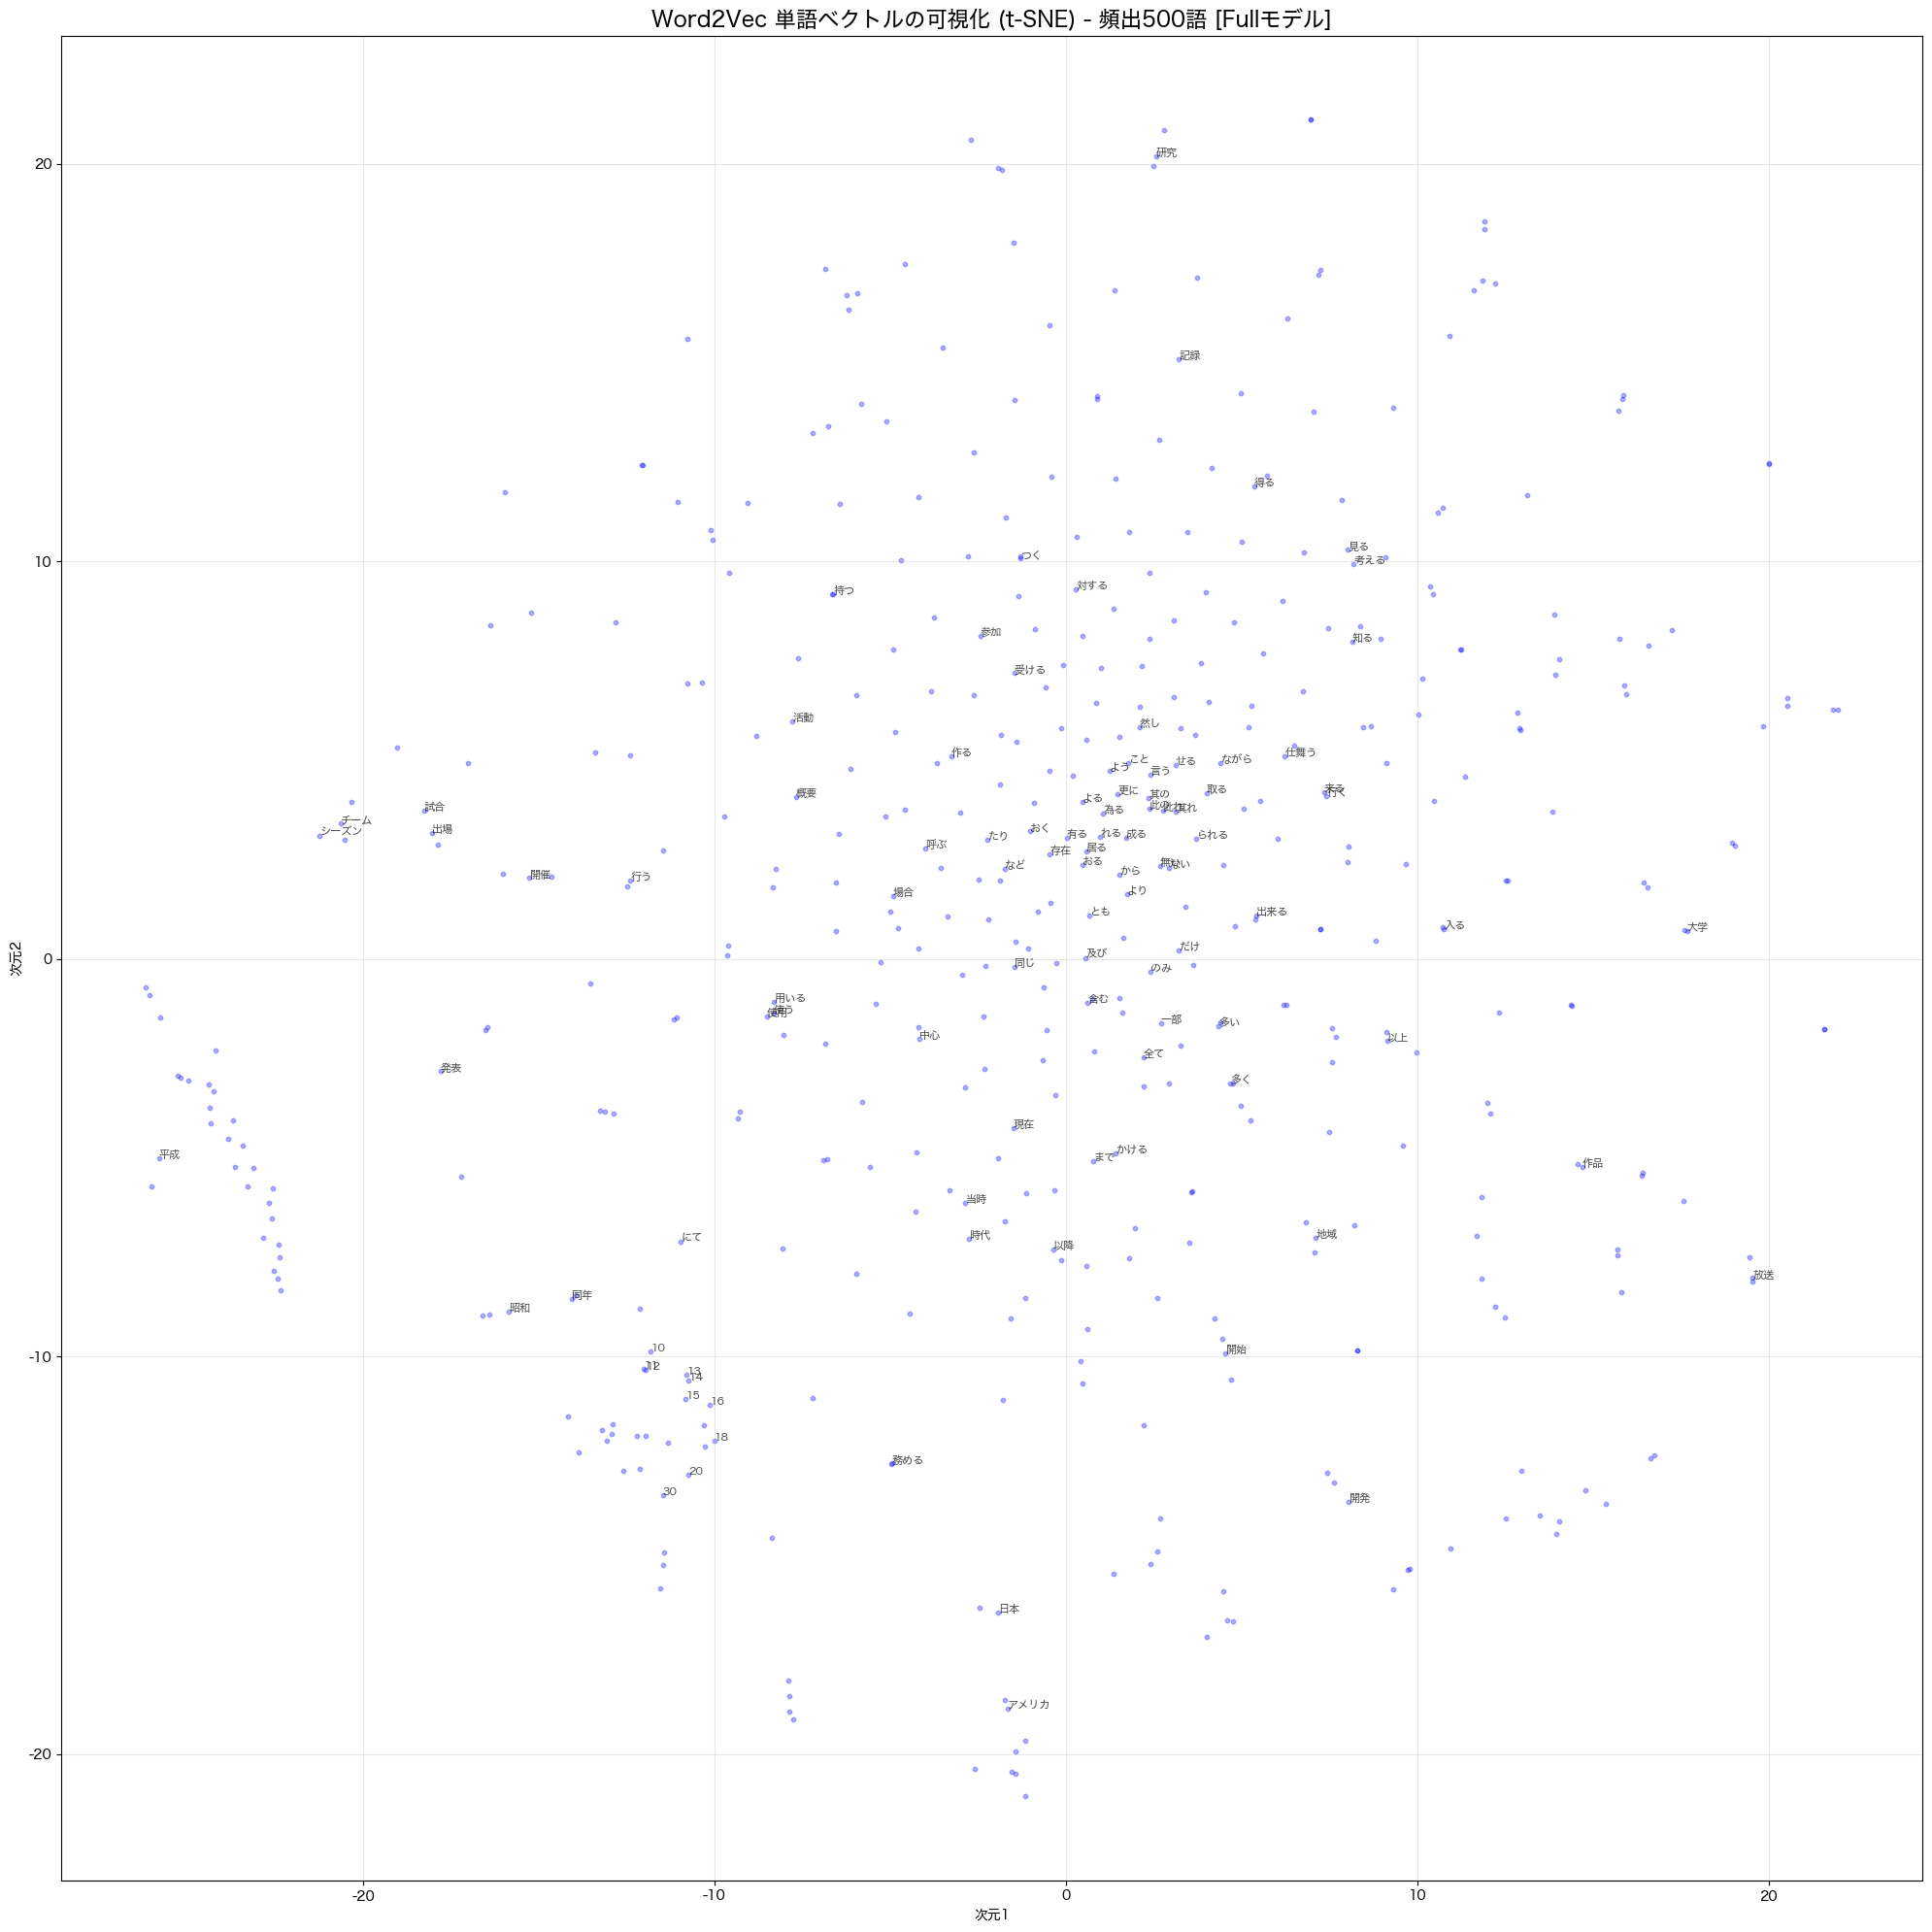

✓ 500語を可視化しました


In [38]:
# 頻出単語の可視化（t-SNE）- Fullモデル
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Fullモデルを使用
try:
    viz_model = full_model
    print(f"使用モデル: full_model (語彙数: {len(viz_model.wv):,}語)")
except NameError:
    print("⚠ full_modelが見つかりません。先にモデルを読み込んでください。")
    viz_model = None

if viz_model is not None:
    # 頻出上位500語を可視化
    vocab_size = min(500, len(viz_model.wv))
    words = list(viz_model.wv.index_to_key[:vocab_size])
    word_vectors = np.array([viz_model.wv[word] for word in words])
    
    print(f"\n{vocab_size}語をt-SNEで2次元に圧縮中...")
    # n_iter → max_iter に修正
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    word_vectors_2d = tsne.fit_transform(word_vectors)
    
    # プロット
    plt.figure(figsize=(20, 20))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.3, s=10, c='blue')
    
    # 一部の単語をラベル表示（100語）
    for i in range(0, min(100, vocab_size)):
        plt.annotate(words[i], 
                    xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                    fontsize=8,
                    alpha=0.7)
    
    plt.title(f'Word2Vec 単語ベクトルの可視化 (t-SNE) - 頻出{vocab_size}語 [Fullモデル]', fontsize=16)
    plt.xlabel('次元1')
    plt.ylabel('次元2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ {vocab_size}語を可視化しました")

語彙に存在する単語: 74語
74語をt-SNEで可視化中...


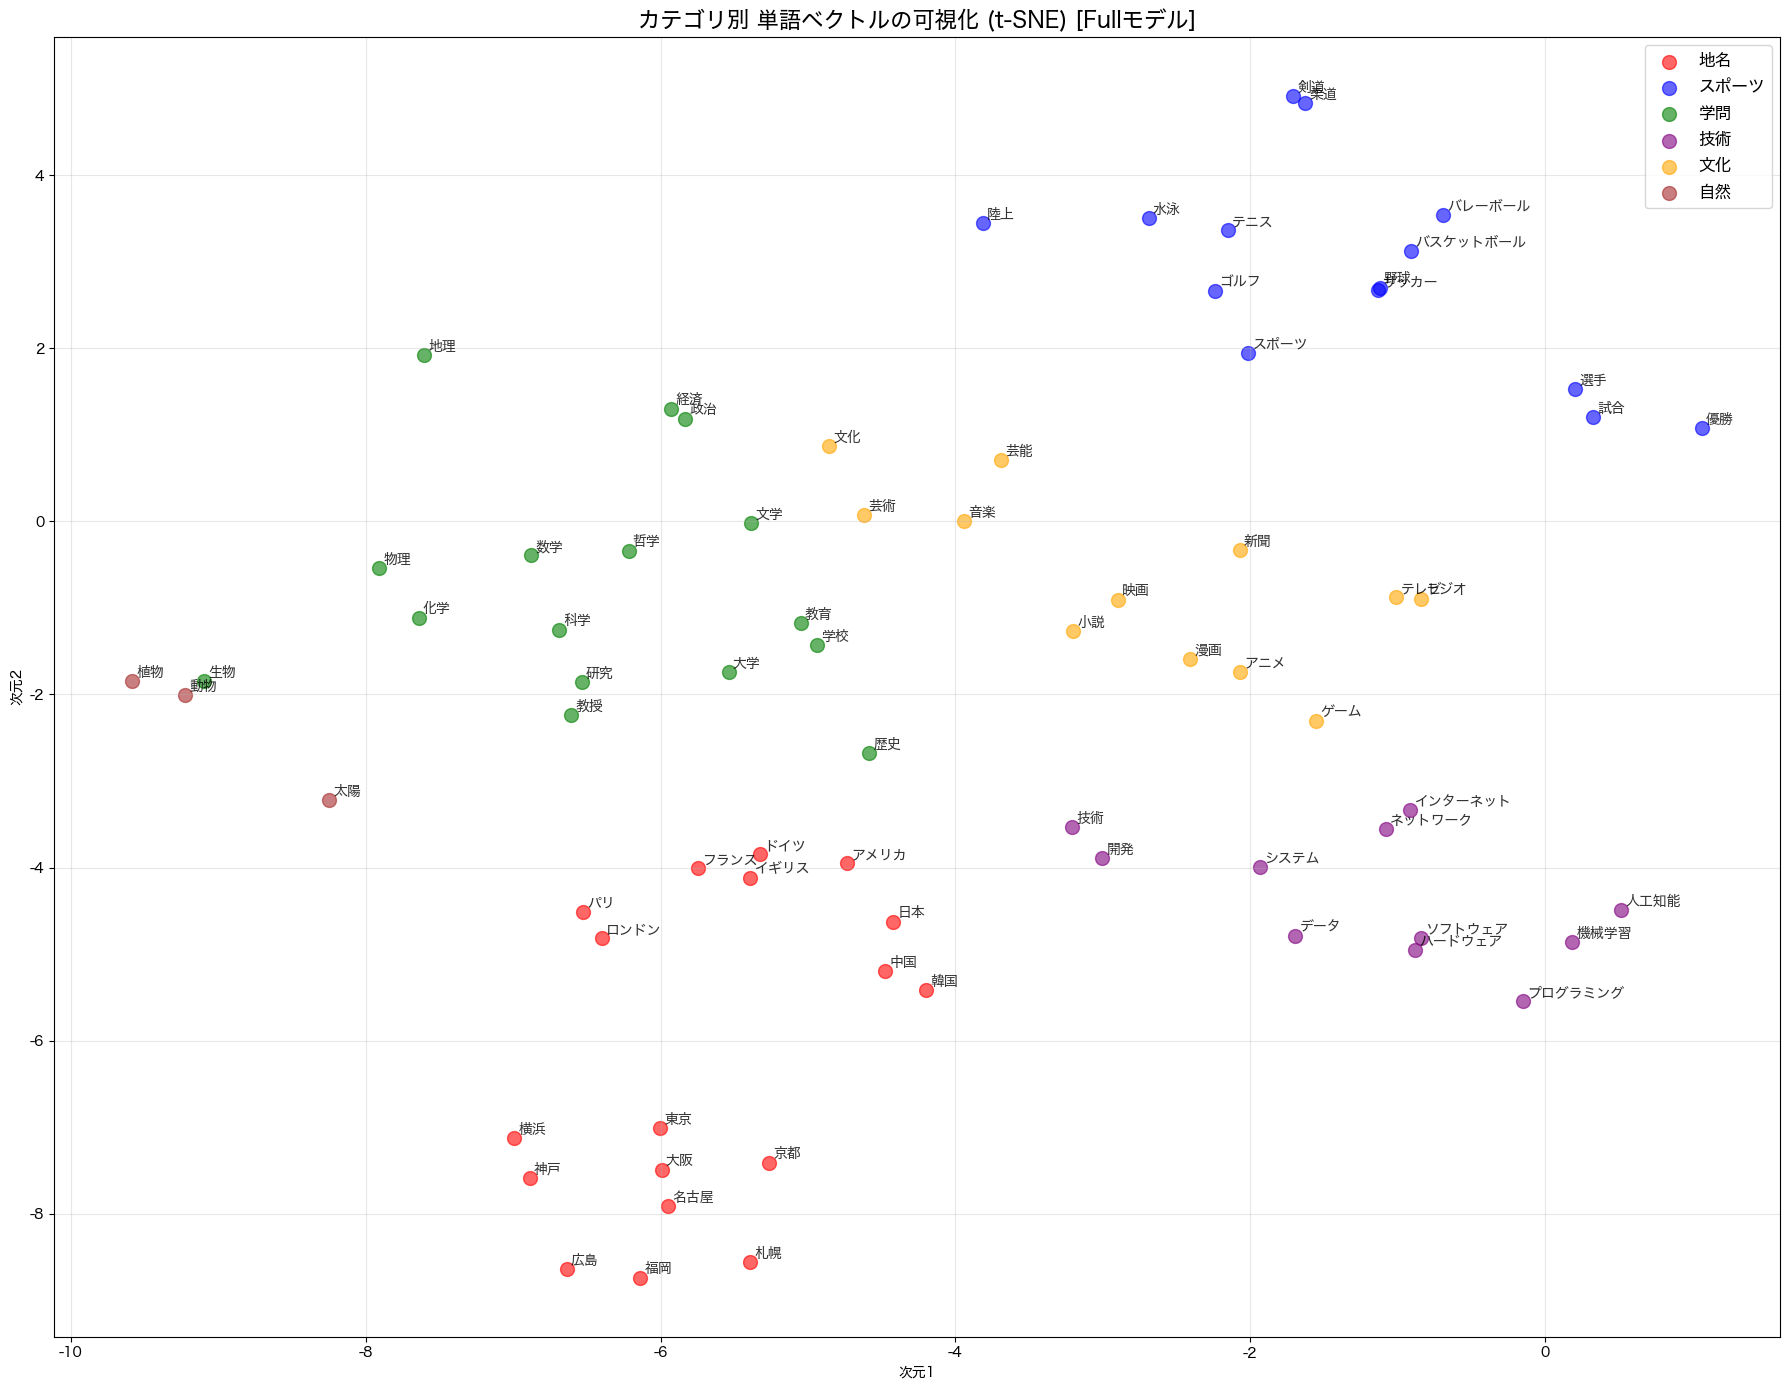

✓ カテゴリ別可視化完了


In [39]:
# カテゴリ別の単語可視化（色分け）- Fullモデル
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# カテゴリ別の単語リスト
categories = {
    "地名": ["日本", "東京", "大阪", "京都", "名古屋", "福岡", "札幌", "横浜", "神戸", "広島",
            "アメリカ", "中国", "韓国", "フランス", "イギリス", "ドイツ", "パリ", "ロンドン"],
    
    "スポーツ": ["野球", "サッカー", "テニス", "バスケットボール", "バレーボール", "ゴルフ", 
                "水泳", "陸上", "柔道", "剣道", "スポーツ", "選手", "試合", "優勝"],
    
    "学問": ["数学", "物理", "化学", "生物", "歴史", "地理", "文学", "哲学", "経済", "政治",
            "科学", "研究", "大学", "教育", "学校", "教授"],
    
    "技術": ["コンピュータ", "プログラミング", "人工知能", "機械学習", "データ", "システム",
            "ソフトウェア", "ハードウェア", "ネットワーク", "インターネット", "技術", "開発"],
    
    "文化": ["音楽", "映画", "小説", "漫画", "アニメ", "ゲーム", "芸術", "文化", "芸能",
            "テレビ", "ラジオ", "新聞"],
    
    "自然": ["山", "川", "海", "森", "空", "雲", "雨", "雪", "風", "太陽", "月", "星",
            "動物", "植物", "花", "木"],
}

# 語彙に存在する単語のみ抽出
all_words = []
word_labels = []
word_colors = []

color_map = {
    "地名": "red",
    "スポーツ": "blue", 
    "学問": "green",
    "技術": "purple",
    "文化": "orange",
    "自然": "brown"
}

for category, words_list in categories.items():
    for word in words_list:
        if word in full_model.wv:
            all_words.append(word)
            word_labels.append(category)
            word_colors.append(color_map[category])

print(f"語彙に存在する単語: {len(all_words)}語")

if len(all_words) > 1:
    # 単語ベクトルを取得
    word_vectors = np.array([full_model.wv[word] for word in all_words])
    
    # t-SNEで2次元に圧縮（max_iterに修正）
    print(f"{len(all_words)}語をt-SNEで可視化中...")
    perplexity = min(30, len(all_words) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    word_vectors_2d = tsne.fit_transform(word_vectors)
    
    # プロット
    plt.figure(figsize=(18, 14))
    
    # カテゴリごとにプロット
    for category in categories.keys():
        indices = [i for i, label in enumerate(word_labels) if label == category]
        if indices:
            x = word_vectors_2d[indices, 0]
            y = word_vectors_2d[indices, 1]
            plt.scatter(x, y, c=color_map[category], label=category, s=100, alpha=0.6)
    
    # 単語ラベルを表示
    for i, word in enumerate(all_words):
        plt.annotate(word, 
                    xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                    xytext=(3, 3),
                    textcoords='offset points',
                    fontsize=10,
                    alpha=0.8)
    
    plt.title('カテゴリ別 単語ベクトルの可視化 (t-SNE) [Fullモデル]', fontsize=16)
    plt.xlabel('次元1')
    plt.ylabel('次元2')
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ カテゴリ別可視化完了")
else:
    print("⚠ 語彙に含まれる単語が不足しています")

可視化対象: 44語
t-SNEで次元削減中...


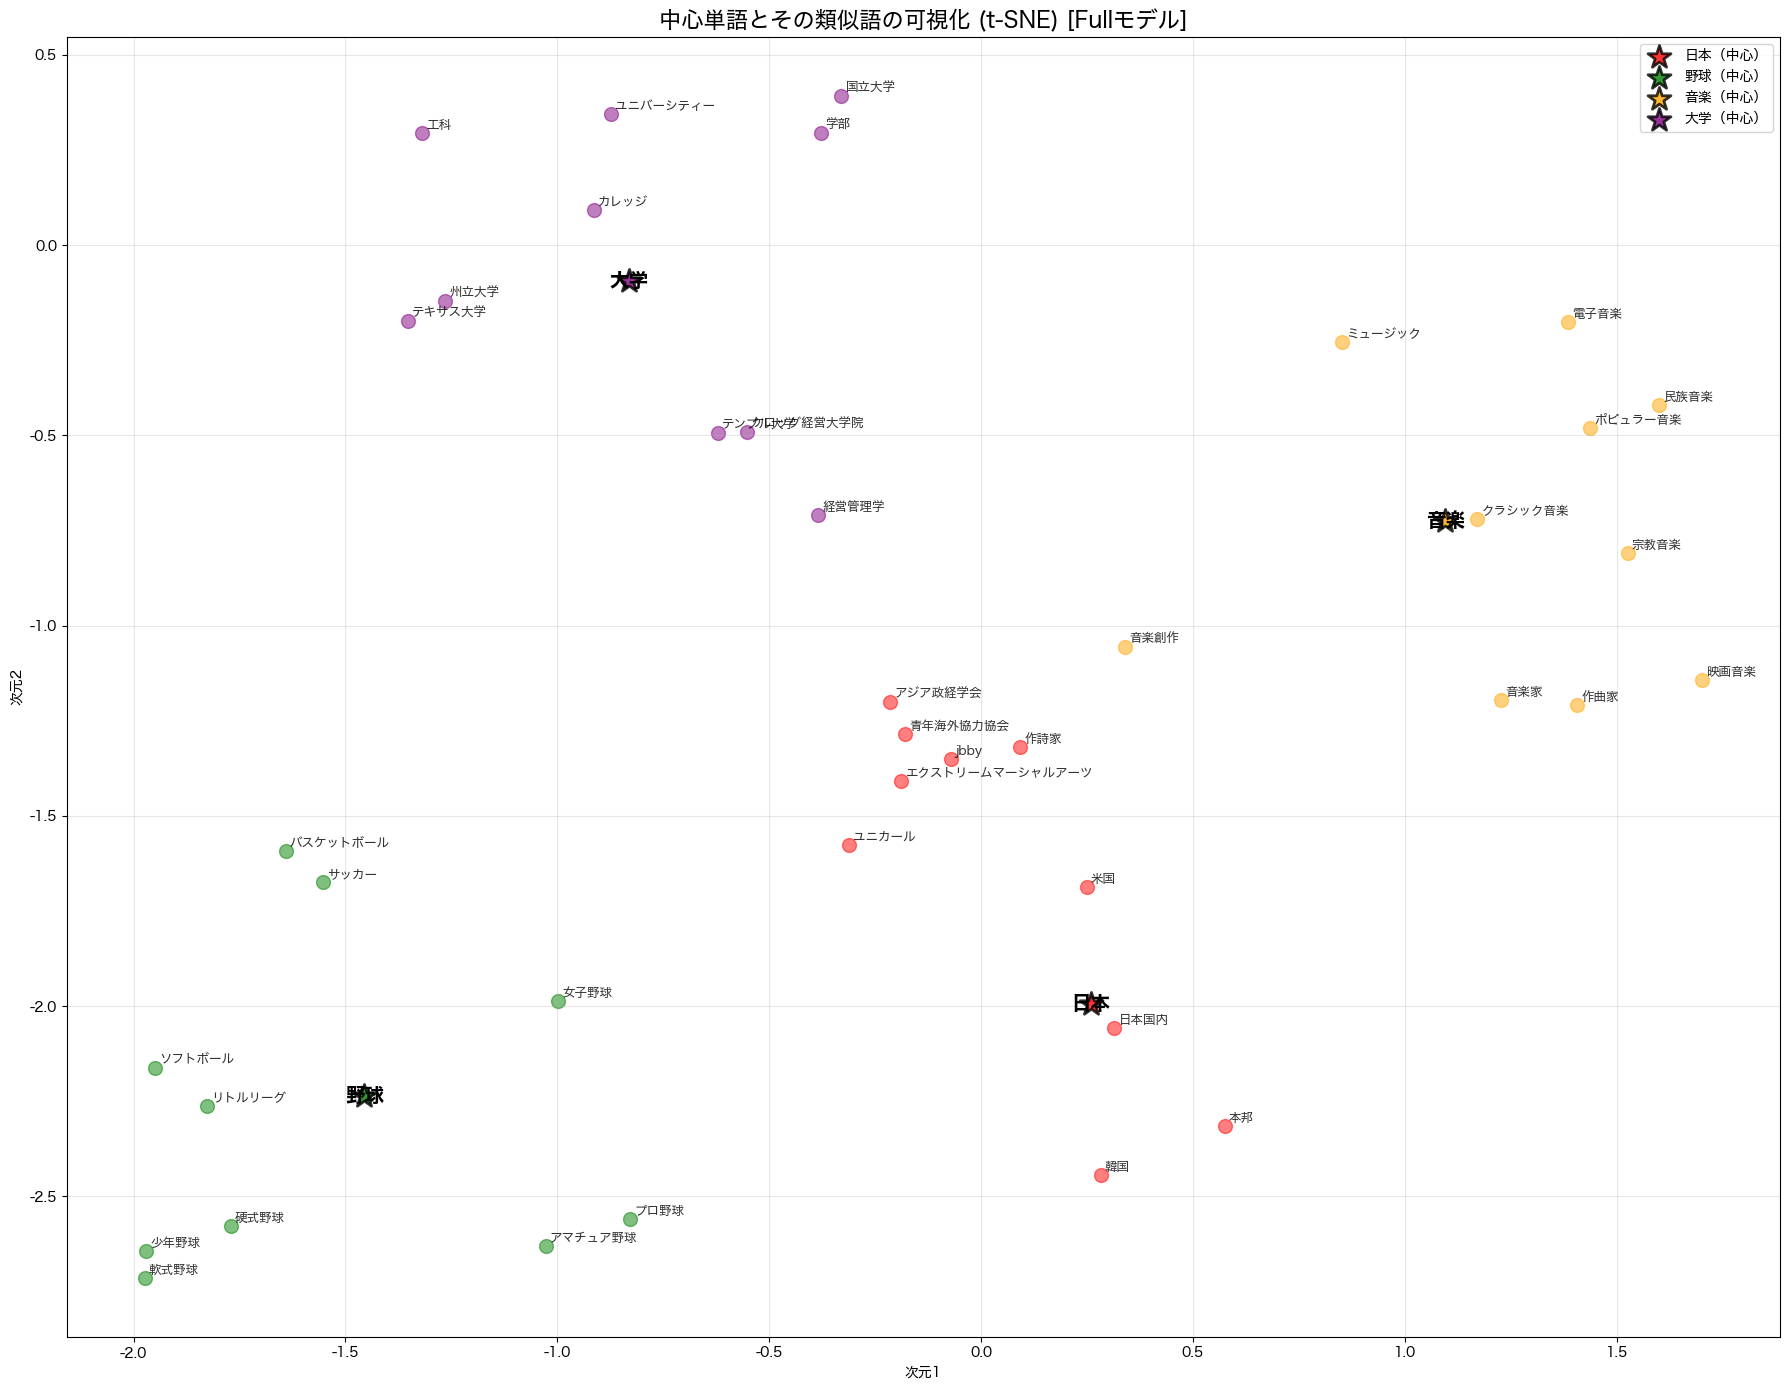

✓ 類似語の可視化完了


In [40]:
# 特定単語とその類似語の可視化 - Fullモデル
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 中心となる単語を指定
center_words = ["日本", "コンピュータ", "野球", "音楽", "大学"]

# 各中心単語とその類似語を収集
all_viz_words = []
word_categories = []

for center_word in center_words:
    if center_word in full_model.wv:
        # 中心単語を追加
        all_viz_words.append(center_word)
        word_categories.append(center_word)
        
        # 類似語Top 10を追加
        similar_words = full_model.wv.most_similar(center_word, topn=10)
        for sim_word, score in similar_words:
            all_viz_words.append(sim_word)
            word_categories.append(center_word)

print(f"可視化対象: {len(all_viz_words)}語")

if len(all_viz_words) > 1:
    # 単語ベクトルを取得
    word_vectors = np.array([full_model.wv[word] for word in all_viz_words])
    
    # t-SNEで2次元に圧縮（max_iterに修正）
    print("t-SNEで次元削減中...")
    perplexity = min(30, len(all_viz_words) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    word_vectors_2d = tsne.fit_transform(word_vectors)
    
    # プロット
    plt.figure(figsize=(18, 14))
    
    # カテゴリ（中心単語）ごとに色分け
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    color_dict = {word: colors[i % len(colors)] for i, word in enumerate(center_words)}
    
    for i, (word, category) in enumerate(zip(all_viz_words, word_categories)):
        x, y = word_vectors_2d[i, 0], word_vectors_2d[i, 1]
        
        # 中心単語は大きく表示
        if word == category:
            plt.scatter(x, y, c=color_dict[category], s=300, alpha=0.8, 
                       edgecolors='black', linewidths=2, marker='*', 
                       label=f'{category}（中心）' if i == all_viz_words.index(word) else '')
            plt.annotate(word, xy=(x, y), fontsize=14, fontweight='bold',
                        ha='center', va='center')
        else:
            plt.scatter(x, y, c=color_dict[category], s=100, alpha=0.5)
            plt.annotate(word, xy=(x, y), xytext=(3, 3),
                        textcoords='offset points', fontsize=9, alpha=0.8)
    
    plt.title('中心単語とその類似語の可視化 (t-SNE) [Fullモデル]', fontsize=16)
    plt.xlabel('次元1')
    plt.ylabel('次元2')
    
    # 凡例（重複を除去）
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✓ 類似語の可視化完了")
else:
    print("⚠ 語彙に含まれる単語が不足しています")

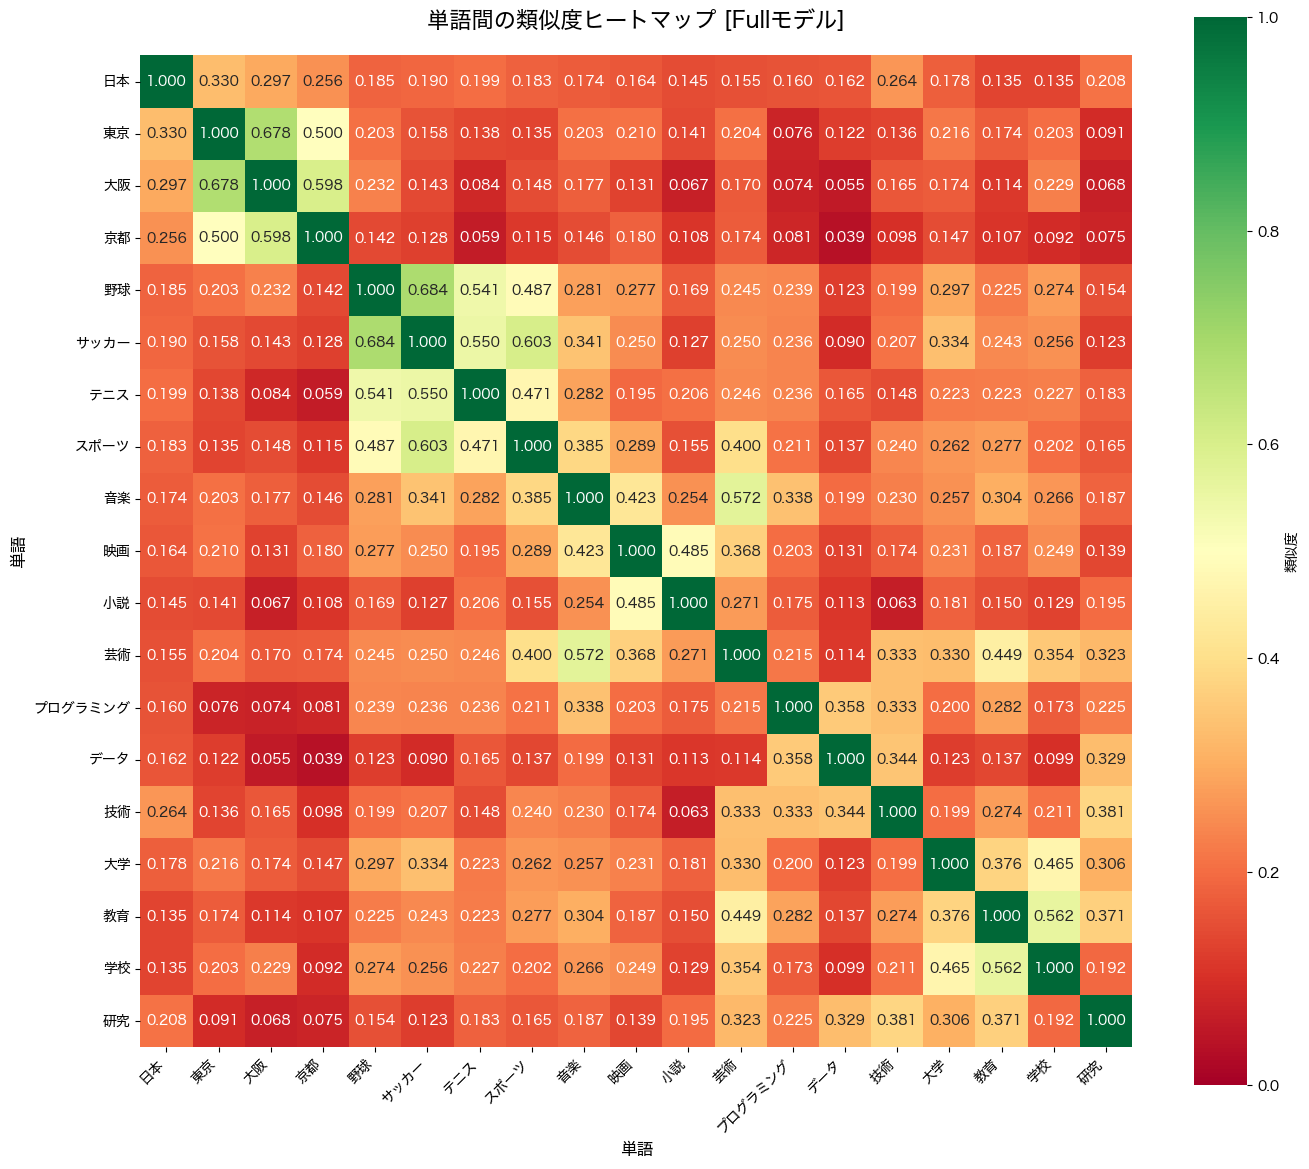

✓ 19語の類似度ヒートマップを作成しました

最も類似度が高いペア（対角線を除く）:
  野球              ⟷ サッカー            : 0.6840
  東京              ⟷ 大阪              : 0.6780
  サッカー            ⟷ スポーツ            : 0.6030
  大阪              ⟷ 京都              : 0.5978
  音楽              ⟷ 芸術              : 0.5722

最も類似度が低いペア:
  京都              ⟷ データ             : 0.0389
  大阪              ⟷ データ             : 0.0550
  京都              ⟷ テニス             : 0.0586
  小説              ⟷ 技術              : 0.0631
  大阪              ⟷ 小説              : 0.0674


In [41]:
# ヒートマップで単語間の類似度を可視化 - Fullモデル
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 分析対象の単語リスト
heatmap_words = [
    "日本", "東京", "大阪", "京都",
    "野球", "サッカー", "テニス", "スポーツ",
    "音楽", "映画", "小説", "芸術",
    "コンピュータ", "プログラミング", "データ", "技術",
    "大学", "教育", "学校", "研究"
]

# 語彙に存在する単語のみ抽出
valid_words = [w for w in heatmap_words if w in full_model.wv]

if len(valid_words) > 1:
    # 類似度行列を作成
    n = len(valid_words)
    similarity_matrix = np.zeros((n, n))
    
    for i, word1 in enumerate(valid_words):
        for j, word2 in enumerate(valid_words):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                similarity_matrix[i, j] = full_model.wv.similarity(word1, word2)
    
    # ヒートマップを描画
    plt.figure(figsize=(14, 12))
    sns.heatmap(similarity_matrix, 
                xticklabels=valid_words, 
                yticklabels=valid_words,
                annot=True,  # 数値を表示
                fmt='.3f',   # 小数点3桁
                cmap='RdYlGn',  # 色マップ（赤→黄→緑）
                vmin=0, vmax=1,  # 範囲を0-1に固定
                square=True,
                cbar_kws={'label': '類似度'})
    
    plt.title('単語間の類似度ヒートマップ [Fullモデル]', fontsize=16, pad=20)
    plt.xlabel('単語', fontsize=12)
    plt.ylabel('単語', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ {len(valid_words)}語の類似度ヒートマップを作成しました")
    
    # 最も類似度が高いペアと低いペアを表示
    print("\n最も類似度が高いペア（対角線を除く）:")
    temp_matrix = similarity_matrix.copy()
    for _ in range(5):
        # 対角線をマスク
        np.fill_diagonal(temp_matrix, -1)
        
        max_idx = np.unravel_index(np.argmax(temp_matrix), temp_matrix.shape)
        i, j = max_idx
        if temp_matrix[i, j] > 0:
            print(f"  {valid_words[i]:15s} ⟷ {valid_words[j]:15s} : {temp_matrix[i, j]:.4f}")
        
        # 使用済みをマスク
        temp_matrix[i, j] = -1
        temp_matrix[j, i] = -1
    
    print("\n最も類似度が低いペア:")
    temp_matrix = similarity_matrix.copy()
    np.fill_diagonal(temp_matrix, 2)  # 対角線を高い値でマスク
    for _ in range(5):
        min_idx = np.unravel_index(np.argmin(temp_matrix), temp_matrix.shape)
        i, j = min_idx
        if temp_matrix[i, j] < 1:
            print(f"  {valid_words[i]:15s} ⟷ {valid_words[j]:15s} : {temp_matrix[i, j]:.4f}")
        
        # 使用済みをマスク
        temp_matrix[i, j] = 2
        temp_matrix[j, i] = 2
    
else:
    print("⚠ 語彙に含まれる単語が不足しています")

## 評価サマリ

上記のテストで以下を評価しました:

1. **類似語検索**: 意味的に近い単語を正しく検索できるか
2. **単語類推**: アナロジー（A:B = C:?）を正しく推論できるか
3. **類似度計算**: 単語間の意味的距離を適切に測定できるか
4. **仲間外れ検出**: 異質な単語を識別できるか
5. **クラスタリング**: 同じカテゴリの単語が近くに配置されているか
6. **ベクトル演算**: 複雑な意味演算が可能か
7. **定量評価**: 関連度に応じた類似度スコアの分離